In [61]:
import torch
from torch import nn
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

from tqdm.auto import tqdm
from pathlib import Path
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
train_data = torchvision.datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
)

test_data = torchvision.datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:08<00:00, 1142949.02it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 228960.11it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1002250.52it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1281914.32it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [12]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )

In [13]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )

In [14]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [16]:
batch_size = 32
num_workers = os.cpu_count()

train_dataloader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers)

test_dataloader = DataLoader(test_data,
                              batch_size=batch_size,
                              num_workers=num_workers)

In [20]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [32]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Text(0.5, 1.0, 'Label: 3')

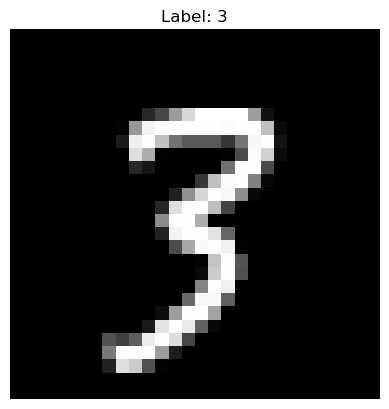

In [57]:
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.axis(False)
plt.title(f'Label: {label}')

In [65]:
class CNNModel(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*7*7, output_shape)
        )
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x
    
model = CNNModel(1, len(class_names), 16).to(device)
model

CNNModel(
  (block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [69]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
acc_fn = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

In [72]:
def train(model,
          dataloader,
          loss_fn,
          optimizer,
          acc_fn,
          device):
    model.to(device)
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += acc_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    
    
def test(model,
         dataloader,
         loss_fn,
         acc_fn,
         device):
    model.to(device)
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += acc_fn(test_pred, y)
            
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%')

In [74]:
torch.manual_seed(42)

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch+1}\n-----------')
    train(model=model,
          dataloader=train_dataloader,
          loss_fn=loss_fn,
          optimizer=optimizer,
          acc_fn=acc_fn,
          device=device)
    test(model=model,
         dataloader=test_dataloader,
         loss_fn=loss_fn,
         acc_fn=acc_fn,
         device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-----------
Train Loss: 1.6214 | Train Acc: 60.67%
Test Loss: 0.5138 | Test Acc: 84.71%
Epoch: 2
-----------
Train Loss: 0.4103 | Train Acc: 87.80%
Test Loss: 0.3357 | Test Acc: 90.01%
Epoch: 3
-----------
Train Loss: 0.3169 | Train Acc: 90.53%
Test Loss: 0.2708 | Test Acc: 92.10%
Epoch: 4
-----------
Train Loss: 0.2683 | Train Acc: 91.95%
Test Loss: 0.2359 | Test Acc: 93.08%
Epoch: 5
-----------
Train Loss: 0.2283 | Train Acc: 93.10%
Test Loss: 0.1939 | Test Acc: 94.21%
Epoch: 6
-----------
Train Loss: 0.1976 | Train Acc: 94.03%
Test Loss: 0.1683 | Test Acc: 94.87%
Epoch: 7
-----------
Train Loss: 0.1713 | Train Acc: 94.86%
Test Loss: 0.1477 | Test Acc: 95.54%
Epoch: 8
-----------
Train Loss: 0.1530 | Train Acc: 95.44%
Test Loss: 0.1311 | Test Acc: 95.98%
Epoch: 9
-----------
Train Loss: 0.1380 | Train Acc: 95.87%
Test Loss: 0.1187 | Test Acc: 96.40%
Epoch: 10
-----------
Train Loss: 0.1267 | Train Acc: 96.19%
Test Loss: 0.1072 | Test Acc: 96.72%


Text(0.5, 1.0, 'Pred Label: 1 | True Label: 1')

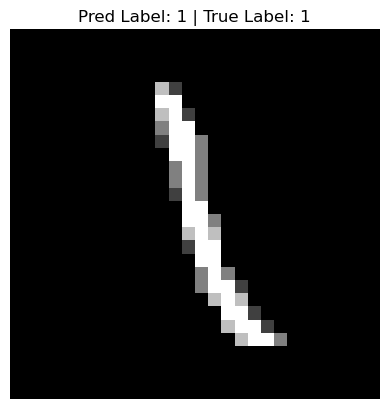

In [96]:
model.eval()

random_idx = torch.randint(0, len(test_data), size=[1]).item()
X, y = test_data[random_idx]

X = X.unsqueeze(0).to(device)

pred_logits = model(X)

pred_target = pred_logits.argmax(dim=1).item()

img = X.squeeze().cpu().numpy()

plt.imshow(img, cmap='gray')
plt.axis(False)
plt.title(f'Pred Label: {pred_target} | True Label: {y}')

In [97]:
model_path = Path('model')
model_path.mkdir(parents=True,
                 exist_ok=True)

model_name = 'digit_recognition_model.pth'
model_save_path = model_path / model_name

print(f'Saving model to: {model_save_path}')
torch.save(obj=model.state_dict(),
           f=model_save_path)

Saving model to: model\digit_recognition_model.pth


In [98]:
loaded_model = CNNModel(1, 10, 16).to(device)

loaded_model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [99]:
from PIL import Image

transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

def load_images(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(folder, filename)
            image = Image.open(image_path).convert('L')
            image = transforms(image)
            images.append(image)
            filenames.append(filename)
    return images, filenames

images, filenames = load_images('./custom_data')
images = torch.stack(images)

In [100]:
loaded_model.to(device)
images = images.to(device)

loaded_model.eval()
with torch.inference_mode():
    pred_logits = model(images)
    _, predicted = torch.max(pred_logits, 1)
    
true_labels = [int(filename.split('.')[0].replace('label', '')) for filename in filenames]

In [101]:
def plot_images(images, filenames, predicted_labels, true_labels):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(5, 5, i+1)  # Adjust the subplot grid size as necessary
        image = images[i].cpu().numpy().squeeze()  # Move image to CPU and remove channel dimension
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

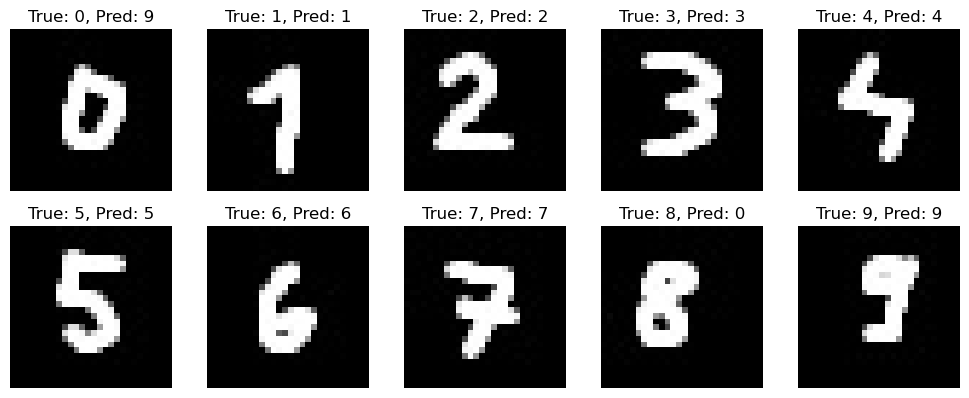

In [102]:
plot_images(images, filenames, predicted, true_labels)